In [273]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm_notebook
import spacy
from spacy import displacy
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import glob
import pickle
import random
from scipy.stats import hmean
import re
from bs4 import BeautifulSoup
import requests
from sklearn.metrics.pairwise import cosine_similarity
import sys

In [2]:
nlp = spacy.load('en_core_web_trf')
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

In [3]:
# Own Functions
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

In [4]:
%matplotlib inline

## CUB preprocessing

In [5]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/classes.txt"
with open(location) as f:
    lines = f.readlines()
    
# Init regex
regex = r'\d+\s\d+\.'
# Clean the list
CUB = [re.sub(regex, '', line).rstrip().replace('_', ' ') for line in lines]

In [6]:
# Open the text file
location = "../data/external/CUB_200_2011/attributes.txt"
with open(location) as f:
    lines = f.readlines()
    
attribute_list = []

# Create a DF with attributes
for line in lines:
    line = line.strip()
    attributes = line.split()[1].split('::')
    part = attributes[0]
    adjective = attributes[1]
    attribute_list.append((part, adjective))
    
# Create DF        
df_attributes = pd.DataFrame(attribute_list, columns=['Part', 'Adj'])
# Reset the index
df_attributes.index = np.arange(1, len(df_attributes)+1)

In [7]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt"
with open(location) as f:
    lines = f.readlines()
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/images.txt"
with open(location) as f:
    img_ids = f.readlines()
    
# Create DF will all present parts
CUB_dict = collections.defaultdict(list)
# Loop over lines
for line in tqdm_notebook(lines):
    data = line.split()
    # Skip non present
    if not int(data[2]):
        continue
    # Skip uncertain things
    if int(data[3]) < 4:
        continue
    # Otherwise append
    #print(CUB[int(img_ids[int(data[0])].split()[1][0:3]) - 1], data)
    CUB_dict[CUB[int(img_ids[int(data[0])-1].split()[1][0:3]) - 1]].append((df_attributes.loc[int(data[1]), ][0], df_attributes.loc[int(data[1]), ][1]))

  0%|          | 0/3677856 [00:00<?, ?it/s]

### Open BOW matched text file
Open the BOW matched text file and reqrite the CUB dataset to match the BOW set

In [8]:
# Open the text file
location = "../data/external/birds_matched.txt"
with open(location) as f:
    lines = f.readlines()

BOW_list = []
for line in lines[1:]:
    line = line.strip()
    _, CUB, BOW = line.split(';')
    BOW_list.append((CUB, BOW))    

In [9]:
# Rewrite the CUB dict
CUB_dict_new = collections.defaultdict(list)

for (CUB, BOW) in BOW_list:
    CUB_dict_new[BOW] = CUB_dict[CUB]

# Attribution

In [10]:
# birds descriptions
data = pickle.load(open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'rb'))
# trained model
model = load_CUB_Bert("../models/", 'saved_weights_CUB_BIRDS_2000.pt')

Local Success


### Helper functions

In [11]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

# Modify the prediction output and define a custom forward
def predict(inputs, attentions):
    return model(input_ids=inputs, attention_mask=attentions)[0]

def custom_forward(inputs, attentions):
    preds = predict(inputs, attentions)
    return torch.exp(preds)

# Tokenize functions
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

# Summarize and vis functions
def summarize_attributions_ig(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def summarize_attributions_occ(attributions):
    return attributions.sum(axis=0)

def token_to_words(attribution, tokens):
    
    words = []
    attributes = []

    for attribute, word in zip(attribution, tokens):

        attribute = attribute.cpu().detach().numpy()
        if word == '[CLS]' or word == '[SEP]':
            words.append(word)
            attributes.append([attribute])
        elif not word.startswith('##'):
            words.append(word)
            attributes.append([attribute])
        elif word.startswith('##'):
            words[-1] += word.strip('##')
            attributes[-1] = np.append(attributes[-1], attribute)

    attribution = [np.sum(mean) for mean in attributes]
    return attribution, words

def colorize(attribution, tokens):
    
    template = """  
    <mark class="entity" style=" background: {}; padding: 0.4em 0.0em; margin: 0.0em; line-height: 2; 
    border-radius: 0.0em; ">{}<span style=" font-size: 0.8em;  font-weight: bold;  line-height: 1; 
    border-radius: 0.0em; text-align-last:center; vertical-align: middle; margin-left: 0rem; "></span></mark>
    """

    colored_string = ''
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.Greens).to_rgba(attribution)
    for idx, (word, color) in enumerate(zip(tokens, normalized_and_mapped)):
        
        word = word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        if word.strip() == '[CLS]' or word.strip() == '[SEP]': 
            color = '#ffffff'
        #print(color)
        colored_string += template.format(color, word)

    return colored_string

def explain(word):
    
    data = collections.defaultdict(list)
       
    # tokenize
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(word, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    indices = input_ids[0].type(torch.LongTensor)
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    #### Layer IG 20 steps
    attribution_ig = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=20,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attributions_ig_sum = summarize_attributions_ig(attribution_ig)
    attributions_ig_words, words = token_to_words(attributions_ig_sum, all_tokens)
    data['Words'] = words
    data['IG_20'] = attributions_ig_words
    ####
    
    #### Layer IG 100 steps
    attribution_ig_100 = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=50,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attribution_ig_100_sum = summarize_attributions_ig(attribution_ig_100)
    attributions_ig_100_words, _ = token_to_words(attribution_ig_100_sum, all_tokens)
    #print(attribution_ig_100_sum)
    data['IG_50'] = attributions_ig_100_words
    ####
    
    ### Occlusion maps 
    attribution_occ = occ.attribute(inputs=(input_ids, attention_mask),
                                sliding_window_shapes=(tuple([1,]), tuple([1,])), 
                                baselines=(ref_input_ids, attention_mask),)
    attributions_occ_sum = summarize_attributions_occ(attribution_occ[0])
    attributions_occ_words, _ = token_to_words(attributions_occ_sum, all_tokens)
    data['Occ_1-1'] = attributions_occ_words
    #### Occlusion maps (3, 2)
    attribution_occ2 = occ.attribute(inputs=(input_ids, attention_mask),
                                sliding_window_shapes=(tuple([3,]), tuple([3,])), 
                                strides=(2, 2), 
                                baselines=(ref_input_ids, attention_mask),)
    attribution_occ2_sum = summarize_attributions_occ(attribution_occ2[0])
    attributions_occ2_words, _ = token_to_words(attribution_occ2_sum, all_tokens)
    data['Occ_3-2'] = attributions_occ2_words
    ####
    
    #### Shapley Value Sampling
    attribution_SVS = SVS.attribute(inputs=(input_ids, attention_mask),
                                baselines=(ref_input_ids, attention_mask),
                                   n_samples=5)
    attributions_SVS_sum = attribution_SVS[0][0]
    attributions_SVS_words, _ = token_to_words(attributions_SVS_sum, all_tokens)
    data['SVS'] = attributions_SVS_words
    ####
    
    ### Layer Activation
    attribution_la = la.attribute(inputs=(input_ids, attention_mask),)
    attributions_la_sum = summarize_attributions_ig(attribution_la)
    attributions_la_words, _ = token_to_words(attributions_la_sum, all_tokens)
    data['LA'] = attributions_la_words
    
    attribution_lgxa = lgxa.attribute(inputs=input_ids,
                                 additional_forward_args=attention_mask,
                                 attribute_to_layer_input=False)
    attributions_lgxa_sum = summarize_attributions_ig(attribution_lgxa)
    attributions_lgxa_words, words = token_to_words(attributions_lgxa_sum, all_tokens)
    data['LGXA'] = attributions_lgxa_words
    
    return data

### Explanatory Methods

In [12]:
from captum.attr import LayerActivation, LayerIntegratedGradients 
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr import Occlusion, FeatureAblation, ShapleyValueSampling
from captum.attr import LayerFeatureAblation
from captum.attr import LayerGradientXActivation

In [13]:
lig     = LayerIntegratedGradients(custom_forward, model.bert.embeddings)
occ     = Occlusion(custom_forward)
ablator = FeatureAblation(custom_forward)
lfa     = LayerFeatureAblation(custom_forward, model.bert.embeddings)
SVS     = ShapleyValueSampling(custom_forward)
la      = LayerActivation(custom_forward, model.bert.embeddings)
lgxa    = LayerGradientXActivation(custom_forward, model.bert.embeddings)

In [14]:
# Single Example
string = 'The bird has an orange bill.'
test_example = explain(string)

In [15]:
# Skip first (contains tokens)
for attribution in list(test_example.keys())[1:]:
    words = test_example['Words']
    string = colorize(test_example[attribution], words)
    print(attribution)
    display(HTML(string))

IG_20


IG_50


Occ_1-1


Occ_3-2


SVS


LA


LGXA


### Extract the attribution for the Common birds

In [ ]:
# Create common list
common_birds = list(CUB_dict_new.keys())
# Init dict
attribution = collections.defaultdict(list)
# Init counter
idx = 0

# Loop over common birds
#for bird in tqdm_notebook(list(data.keys())[0:2], desc='Bird'):
for bird in tqdm_notebook(common_birds[0:], desc='Bird'):
    # Get descriptions
    text_list = [text for text in data[bird]]
    # Get attribution values
    for text in tqdm_notebook(text_list[0:], desc='Text', leave=False):
        d = explain(text)
        d['Sentence'] = len(d['Words']) * [idx]
        d['Bird'] = len(d['Words']) * [bird]
        for key in d.keys():
            attribution[key] += d[key]
        
        idx += 1

In [ ]:
#with open('../data/processed/attribution.pkl', 'wb') as f:
#    pickle.dump(attribution, f)

#### Open de attribution pickle 

In [16]:
# Open pickle
attributions = pickle.load(open('../data/processed/attribution.pkl', 'rb'))
# Drop into a df
df = pd.DataFrame.from_dict(attributions)

In [17]:
df.head(12)

,Words,IG_20,IG_50,Occ_1-1,Occ_3-2,SVS,LA,LGXA,Sentence,Bird
0,[CLS],0.000000,0.000000,0.000000e+00,5.960464e-08,5.401671e-09,-0.223453,-0.025956,0,House Sparrow
1,throat,-0.168242,0.348226,1.132721e-07,5.960464e-08,1.676381e-09,-0.349345,-0.292928,0,House Sparrow
2,tends,-0.631331,0.594019,1.192093e-07,5.960464e-08,-8.940697e-09,-0.471691,-0.363891,0,House Sparrow
3,grayish,0.070013,0.079125,1.452063e-07,1.490116e-07,2.672896e-08,0.008562,0.349053,0,House Sparrow
4,in,0.174736,0.054722,-5.355105e-08,5.960464e-08,3.818422e-09,0.179425,0.566078,0,House Sparrow
5,males,0.447279,-0.296187,1.403423e-07,0.000000e+00,-1.788139e-08,-0.358060,-0.226430,0,House Sparrow
6,",",-0.361327,0.478727,9.376026e-08,-5.960464e-08,-1.248263e-08,0.170956,0.078143,0,House Sparrow
7,whitish,-0.008795,-0.008429,3.696186e-09,5.960464e-08,-1.247972e-08,-0.459783,0.434464,0,House Sparrow
8,in,-0.250499,0.321755,-4.035610e-08,5.960464e-08,3.464520e-08,0.255319,0.210366,0,House Sparrow
9,females,0.139122,-0.069630,8.365760e-08,8.940697e-08,-5.215406e-08,-0.334392,-0.321600,0,House Sparrow


#### Get Birds Glossary List

In [18]:
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_bird_terms'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   
# Find embedded glossary
glossaries = soup.find_all('dt', {'class': 'glossary'})
parts = [part.text.lower().strip() for part in glossaries]
# Get additional anchors ("also know as...")
glossaries_other = soup.find_all('span', {'class': 'anchor'})
parts_other = [part['id'].lower().strip() for part in glossaries_other]
# Append and drop duplicates
parts = list(set((parts + parts_other)))
# Replace underscore with space
glossary = [part.replace('_', ' ') for part in parts]

#### Compare with the Glossary
Extract the most important word per attribution method and per trait.

In [ ]:
attribution_words = []
# Extract highest attributions
for idx in tqdm_notebook(df['Sentence'].unique()):
#for idx in tqdm_notebook(range(0, 500)):
    doc = nlp(' '.join(df[df['Sentence'] == idx]['Words']))
    if len(doc) <= 2:
        continue
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    traits =  set(words) & set(glossary)
    if traits:
        # Yield the traits
        trait_list = list(traits)
        #print(trait_list)
        for trait in trait_list:
            for column in df.columns[1:-2]:
                #print(column)
                index = df[df['Sentence'] == idx][column].sort_values(ascending=False)
                attribution_words.append((idx, column, df.iloc[index.index[0]].Words, trait, df.iloc[index.index[0]].Bird))

In [ ]:
#with open('../data/processed/attribution_words.pkl', 'wb') as f:
#    pickle.dump(attribution_words, f)

In [19]:
attribution_words = pickle.load(open('../data/processed/attribution_words.pkl', 'rb'))

Rewrite the CUB-200 dataset. It now contains Adjectives and Parts but still with underscore and irrelevant words. We want a single text chunk to compare the entire chunk at once with the other text chunks.

In [20]:
text_CUB = []
# Rewrite the sentence
for bird in tqdm_notebook(CUB_dict_new.keys()):
    for (part, adjective) in CUB_dict_new[bird]:
        part = part[4:].replace('_', ' ')
        adjective = ' '.join(adjective.split('_'))
        text_CUB.append((part, adjective, bird))

  0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
# Dump in dataframe
df_CUB = pd.DataFrame(text_CUB, columns =['Part', 'Adjective', 'Bird'])
# Create single text chunk
df_CUB['Trait'] = df_CUB['Part'] + ' ' + df_CUB['Adjective']

In [22]:
df_CUB

,Part,Adjective,Bird,Trait
0,underparts color,grey,House Sparrow,underparts color grey
1,breast pattern,solid,House Sparrow,breast pattern solid
2,head pattern,plain,House Sparrow,head pattern plain
3,breast color,grey,House Sparrow,breast color grey
4,throat color,grey,House Sparrow,throat color grey
...,...,...,...,...
222106,tail pattern,solid,Brandt's Cormorant,tail pattern solid
222107,belly pattern,solid,Brandt's Cormorant,belly pattern solid
222108,primary color,black,Brandt's Cormorant,primary color black
222109,crown color,black,Brandt's Cormorant,crown color black


Also drop the most important words + parts in a dataframe for comparison.

In [23]:
# Own = own data
df_OWN = pd.DataFrame(attribution_words, columns =['Sentence', 'Attribution', 'Adjective', 'Part', 'Bird'])
# And also create single text chunk
df_OWN['Trait'] = df_OWN['Part'] + ' ' + df_OWN['Adjective']

In [248]:
df_OWN

,Sentence,Attribution,Adjective,Part,Bird,Trait
0,0,IG_20,males,throat,House Sparrow,throat males
1,0,IG_50,tends,throat,House Sparrow,throat tends
2,0,Occ_1-1,.,throat,House Sparrow,throat .
3,0,Occ_3-2,grayish,throat,House Sparrow,throat grayish
4,0,SVS,in,throat,House Sparrow,throat in
...,...,...,...,...,...,...
280947,23839,Occ_1-1,",",wingspan,Brandt's Cormorant,"wingspan ,"
280948,23839,Occ_3-2,on,wingspan,Brandt's Cormorant,wingspan on
280949,23839,SVS,cm,wingspan,Brandt's Cormorant,wingspan cm
280950,23839,LA,on,wingspan,Brandt's Cormorant,wingspan on


In [233]:
len(df_OWN[df_OWN['Attribution'] == 'LGXA']['Bird'].unique())

199

In [246]:
for attribution in df_OWN['Attribution'].unique():
    print(attribution, len(df_OWN[df_OWN['Attribution'] == attribution]['Trait'].unique()))

IG_20 15288
IG_50 15239
Occ_1-1 14966
Occ_3-2 14132
SVS 13617
LA 3135
LGXA 8911


In [25]:
# Init SIMmodel
SIMmodel = load_simBERT()

In [ ]:
comparison_list = []

for bird in tqdm_notebook(df_OWN['Bird'].unique(), desc='bird'):
    for part in tqdm_notebook(df_OWN['Part'].unique(), desc='part', leave=False):
        # Get CUB DATA
        CUB_subset = list(df_CUB[
            (df_CUB['Trait'].str.startswith(part)) & 
            (df_CUB['Bird'] == bird)]
                         ['Trait'])
        if CUB_subset:
            # Get the vector values
            CUB_subset = list(set(CUB_subset))
            vectors_CUB = vector_values(CUB_subset, model=SIMmodel)
            # Get the attribution
            for attribution in df_OWN['Attribution'].unique():
                #print(bird, attribution, part)
                RANDOM_subset = list(df_OWN[
                    (df_OWN['Bird'] == bird) & 
                    (df_OWN['Part'] == part) &
                    (df_OWN['Attribution'] == attribution)]
                                    ['Trait'])
                # Some part do not exists with birds
                if RANDOM_subset:
                    # Get vectors
                    vectors_RANDOM = vector_values(RANDOM_subset, model=SIMmodel)
                    # Compute similarity
                    matrix = cosine_similarity(vectors_CUB, vectors_RANDOM)
                    # Append    
                    comparison_list.append((bird, part, attribution, matrix))
                    #comparison_list.append((bird, part, attribution, matrix.mean(axis=0)))
                    #comparison_list.append((bird, part, attribution, matrix.max()))
                    #comparison_list.append((bird, part, attribution, hmean(matrix.max(axis=1))))
                    # Clear memory 
                    del vectors_RANDOM
            # Clear memory    
            del vectors_CUB

Compute the similarity for every text of chunk. This goes per bird/per attribution/per part. If computing this at a higher level the memory will explode.

In [119]:
comparison_list = pickle.load(open('../data/processed/comparison_list.pkl', 'rb'))

In [120]:
df_ATB = pd.DataFrame(comparison_list,
                              columns=['Bird', 'Part', 'Attribution', 'Value', 'CUB', 'Random'])

In [122]:
df_ATB['Max'] = df_ATB['Value'].apply(np.max)
df_HM = df_ATB.groupby(['Attribution'])['Max'].apply(hmean).to_frame()
df_melt = pd.melt(df_ATB, id_vars=['Attribution'], value_vars=['Max'])

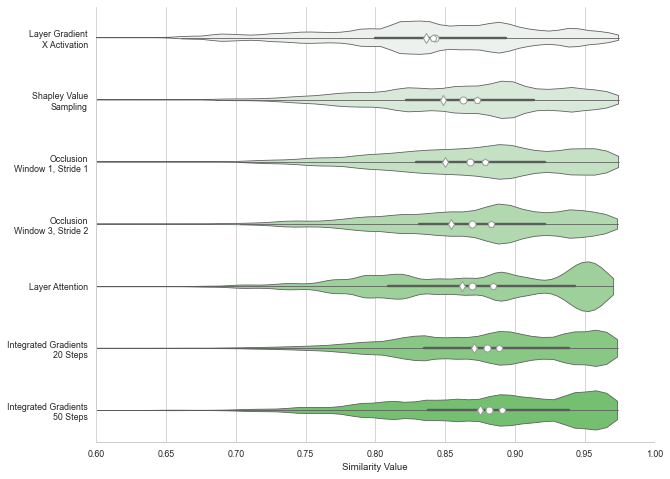

In [463]:

fig, ax = plt.subplots(figsize=(10, 8))
sns.set(style="whitegrid", palette="light:g", color_codes=True)
sns.set_context("paper", rc={"lines.linewidth": 0.8})


df_HM = df_ATB.groupby(['Attribution'])['Max'].apply(hmean).to_frame()
df_MN = df_ATB.groupby(['Attribution'])['Max'].apply(np.mean).to_frame()
df_MD = df_ATB.groupby(['Attribution'])['Max'].apply(np.median).to_frame()
order = df_ATB.groupby("Attribution")["Max"].mean().fillna(0).sort_values(ascending=False)[::-1].index

# Plot the orbital period with horizontal boxes
ax = sns.violinplot(x="value", y="Attribution", data=df_melt,
                 whis=np.inf,  palette="light:g",  order = order, bw=.10, cut=0,
                   inner='box')

#ax = sns.boxplot(x="value", y="Attribution", data=df_melt,
#                  palette="light:g",  order = order)


sns.stripplot(x=df_HM['Max'], y=df_HM.index,  order = order,
              jitter=False, size=7, linewidth=1, color='white',
             marker="d")


sns.stripplot(x=df_MN['Max'], y=df_MN.index,  order = order,
              jitter=False, size=7, linewidth=1, color='white',
             marker="o")

sns.stripplot(x=df_MD['Max'], y=df_MD.index,  order = order,
              jitter=False, size=7, linewidth=1, color='white',
             marker="p")



ax.set_xlim(left=0.6, right=1.0)
ax.set_xticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
ax.set_xlabel('Similarity Value')
ax.set_ylabel('')


ax.set_yticklabels([
    'Layer Gradient\nX Activation',
    'Shapley Value\nSampling',
    'Occlusion\nWindow 1, Stride 1',
    'Occlusion\nWindow 3, Stride 2',
    'Layer Attention',
    'Integrated Gradients\n20 Steps',
    'Integrated Gradients\n50 Steps',
])

# Make the quantitative axis logarithmic
#ax.set_xscale("log")
sns.despine(trim=True)
#fig.savefig('hmean_violinplot.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [187]:
order

Index(['IG_50', 'IG_20', 'LA', 'Occ_3-2', 'Occ_1-1', 'SVS', 'LGXA'], dtype='object', name='Attribution')

# Create a New Dataset

In [362]:
# Load the data
data = pickle.load(open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'rb'))

In [363]:
def IG_50(sentence):
    
    # tokenize
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(sentence, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    indices = input_ids[0].type(torch.LongTensor)
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    #### Layer IG 100 steps
    attribution_ig_100 = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=50,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attribution_ig_100_sum = summarize_attributions_ig(attribution_ig_100)
    attributions_ig_100_words, words = token_to_words(attribution_ig_100_sum, all_tokens)

    return attributions_ig_100_words, words

In [452]:
strings =  data['Bobolink']

In [434]:
#strings

In [435]:
strings = [
     'Note rigid, sharply pointed rectrices, which are distinctive in all plumages.'
]

In [464]:
trait_list = collections.defaultdict(list)
bird = 'Bobolink'

for string in tqdm_notebook(strings, desc='String'):
    

    
    attribution = np.NINF
    candidate = ''
    doc = nlp(string)
    Grad50_data, Grad50_words = IG_50(doc.text)


    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    traits =  set(words) & set(glossary)


    for token in doc:
        if token.text.lower() in traits:
            attribution = np.NINF
            candidate = ''
            HEAD = token.head
            #print(HEAD)
            
            children = [child for child in HEAD.children] + [child for child in token.children]
            
            for child in children:
                if child.text in traits:
                    continue
                else:
                    try:
                        idx = Grad50_words.index(child.text.lower())
                        if Grad50_data[idx] > attribution:
                            if child.pos_ in ['ADJ', 'NOUN', 'VERB']:
                                attribution = Grad50_data[idx]
                                candidate = Grad50_words[idx]
                    # Exception for special tokens
                    except:
                        continue

            trait_list[bird].append((candidate, token.lemma_))
                #print(f'{candidate} {token.lemma_}')


String:   0%|          | 0/117 [00:00<?, ?it/s]

In [458]:
trait_list

defaultdict(list,
            {'Bobolink': [('horn', 'bill'),
              ('capital', 'tract'),
              ('edged', 'tertial'),
              ('proximal', 'covert'),
              ('proximal', 'remex'),
              ('', 'rectrix'),
              ('outermost', 'primary'),
              ('yellow', 'primary'),
              ('outer', 'primary'),
              ('underwing', 'covert'),
              ('outer', 'primary'),
              ('preformative', 'molt'),
              ('', 'plumage'),
              ('features', 'rectrix'),
              ('contour', 'feather'),
              ('alternate', 'plumage'),
              ('down', 'feather'),
              ('down', 'filoplume'),
              ('', 'feather'),
              ('', 'upperpart'),
              ('', 'tertial'),
              ('hind', 'claw'),
              ('hind', 'rectrix'),
              ('alternate', 'plumage'),
              ('', 'tail'),
              ('', 'wing'),
              ('', 'rectrix'),
              ('alular'

In [438]:
displacy.render(doc)

In [442]:
HEAD

in

In [386]:
# Create common list
common_birds = list(CUB_dict_new.keys())

In [459]:
len(common_birds)

200